# MNIST Image Recognition with Convolutional Neural Network

Author: Greg Strabel

This notebook takes the code from [this example](https://keras.rstudio.com/articles/examples/mnist_cnn.html) and adds a few plots as well as a confusion matrix classification report to give the reader a better feel for the power of a simple CNN.

In [18]:
library(keras)
library(reticulate)

# Data Preparation -----------------------------------------------------

batch_size <- 128
num_classes <- 10
epochs <- 1

# Input image dimensions
img_rows <- 28
img_cols <- 28

# The data, shuffled and split between train and test sets
mnist <- dataset_mnist()
x_train <- mnist$train$x
y_train <- mnist$train$y
x_test <- mnist$test$x
y_test <- mnist$test$y

# Redefine  dimension of train/test inputs
x_train <- array_reshape(x_train, c(nrow(x_train), img_rows, img_cols, 1), order = 'F')
x_test <- array_reshape(x_test, c(nrow(x_test), img_rows, img_cols, 1), order = 'F')
input_shape <- c(img_rows, img_cols, 1)

# Transform RGB values into [0,1] range
x_train <- x_train / 255
x_test <- x_test / 255

cat('x_train_shape:', dim(x_train), '\n')
cat(nrow(x_train), 'train samples\n')
cat(nrow(x_test), 'test samples\n')

# Convert class vectors to binary class matrices
y_train <- to_categorical(y_train, num_classes)
y_test <- to_categorical(y_test, num_classes)

x_train_shape: 60000 28 28 1 
60000 train samples
10000 test samples


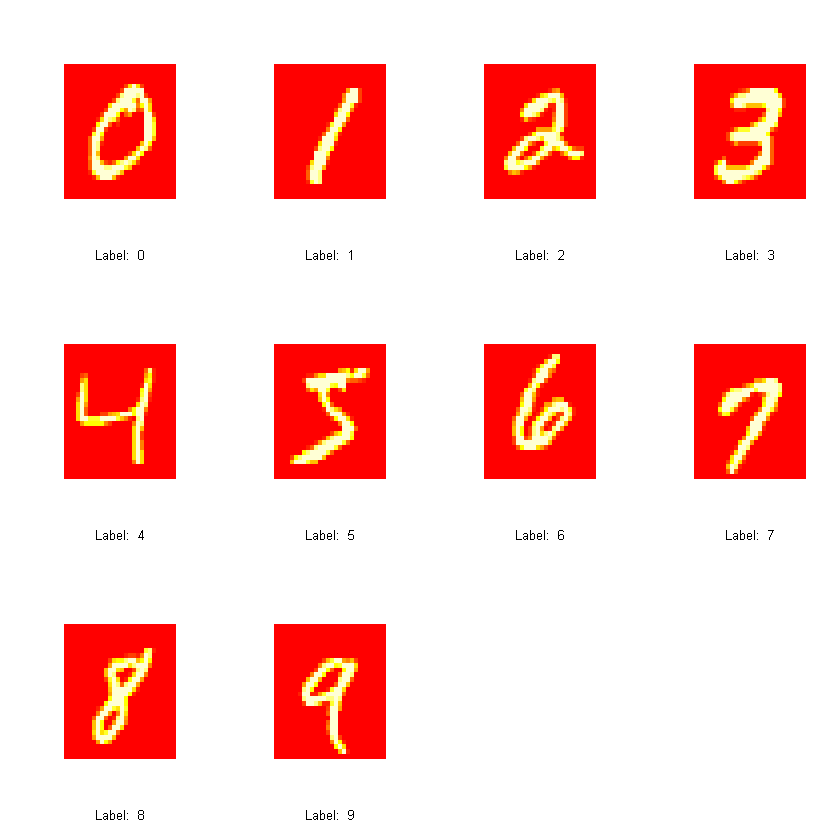

In [67]:
# Take a look at one training example for each character
layout(matrix(1:12,nr=3,byr=T))
for(i in 1:10){
    image(t(apply(as.matrix(x_train[which.max(y_train[,i]),,,]),2,rev)),axes=FALSE, xlab = paste('Label: ',i-1))
}

In [58]:
# Define Model -----------------------------------------------------------

model <- keras_model_sequential()
model %>%
  layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = 'relu',
                input_shape = input_shape) %>% 
  layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = 'relu') %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_dropout(rate = 0.25) %>% 
  layer_flatten() %>% 
  layer_dense(units = 128, activation = 'relu') %>% 
  layer_dropout(rate = 0.5) %>% 
  layer_dense(units = num_classes, activation = 'softmax')

# Compile model
model %>% compile(
  loss = loss_categorical_crossentropy,
  optimizer = optimizer_adadelta(),
  metrics = c('accuracy')
)

# Train & Evaluate -------------------------------------------------------

model %>% fit(
  x_train, y_train,
  batch_size = batch_size,
  epochs = epochs,
  verbose = 1,
  validation_data = list(x_test, y_test)
)
scores <- model %>% evaluate(
  x_test, y_test, verbose = 0
)

# Output metrics
cat('Test loss:', scores[[1]], '\n')
cat('Test accuracy:', scores[[2]], '\n')


Test loss: 0.07456694 
Test accuracy: 0.9764 


In [69]:
# Predict the class of each observation in the test data
test_pred_class <- model %>% predict_classes(x_test)

In [82]:
# Display the confusion matrix and classification report
library(caret)
print(confusionMatrix(test_pred_class,max.col(y_test)-1))

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2    3    4    5    6    7    8    9
         0  973    0    7    0    1    2    6    1    5    6
         1    0 1124    7    0    1    1    3    5    1    5
         2    0    1  991    1    2    0    0   11    1    0
         3    0    3   10  991    0    5    0    5    3    3
         4    0    0    3    0  965    0    4    0    4   10
         5    1    0    0    7    0  877    4    0    2    6
         6    2    4    1    0    6    4  939    0    1    0
         7    1    1   10    8    0    2    0 1000    8   10
         8    3    2    3    3    2    1    2    2  943    8
         9    0    0    0    0    5    0    0    4    6  961

Overall Statistics
                                          
               Accuracy : 0.9764          
                 95% CI : (0.9732, 0.9793)
    No Information Rate : 0.1135          
    P-Value [Acc > NIR] : < 2.2e-16       
                                         

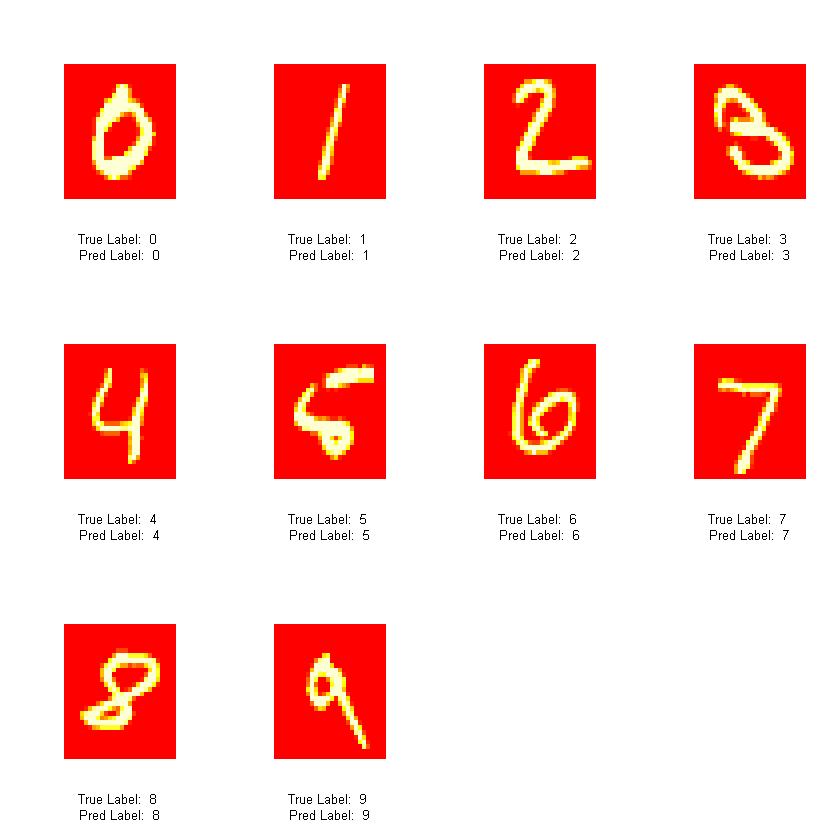

In [74]:
# For each character, display the first true instance of it in the test dataset along with the model prediction
layout(matrix(1:12,nr=3,byr=T))
for(i in 1:10){
    idx = which.max(y_test[,i])
    image(t(apply(as.matrix(x_test[idx,,,]),2,rev)),axes=FALSE,
          xlab = paste('True Label: ',i-1, '\nPred Label: ',test_pred_class[idx]))
}